# UCI DH MTB Race Analysis
## Setup
#### Import Libraries

If you do not have these libraries available, you should install them using `pip`

In [58]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_HALF_UP
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib as mpl
import math
import re
import os
from colour import Color
from cycler import cycler

Widen display area to prevent column wrapping, and always show all columns for debug

In [2]:
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': False})

## Config

Analysis choices

Race:
1. Losinj
1. Fort William
1. Leogang
1. Val di Sole
1. Vallnord
1. Mont-Sainte-Anne
1. La Bresse

Gender:
- m: Men
- f: Women

Other:
- `topX`: How many racers are we interested in comparing?
- `splits`: How many timing splits are there in the race?
- `image_gen`: Should we auto-produce and save to disk high-dpi versions of each chart?

In [41]:
event = 'dh'
race = 2
gender = 'm'
topX = 20
splits = 5 # Could detect this from dataset, or or they always 5? @todo
image_gen = True
dpi = 300

Some internal script config, don't change these. Race list is imported from external python config file

In [4]:
from config import races

racename = races[race]['name']
raceName = races[race]['title']
chart_title_prefix = raceName + ( ', Men' if gender == 'm' else ', Female' )

#### Import Data


Filename setup

In [5]:
directory = event + str(race) + '_' + racename
file_prefix = event + str(race) + '_' + racename + '_' + gender
file_prefix = os.path.join( directory, file_prefix )

Read the CSV file, then clear out the DNF/DNS entries

In [6]:
df = pd.read_csv( file_prefix + '.results.csv', index_col=0 )
# df = df.dropna() # remove DNF/DNS

dfm = pd.read_csv( file_prefix + '.merged.csv', index_col=0 )
df = dfm

Do some input checks and error corrects

In [7]:
if topX > len(df):
    topX = len(df)

Peek at the data if we wish to make sure it looks correct 

In [8]:
display( df.head() )
# display( df.tail() )
# display( dfr.head() )
# display( dfm.head() )

,bib,id,name,q_rank,q_speed,q_split1,q_split2,q_split3,q_split4,q_split5,q_start,q_start_rev,q_status,uci,q_points,r_points,rank,speed,split1,split2,split3,split4,split5,start,start_rev,status,points,qr_diff,q_split1_rank,q_split1_vs_best,q_split1_vs_winner,q_split2_rank,q_split2_vs_best,q_split2_vs_winner,q_split2_sector,q_split2_sector_rank,q_split2_sector_vs_best,q_split2_sector_vs_winner,q_split3_rank,q_split3_vs_best,q_split3_vs_winner,q_split3_sector,q_split3_sector_rank,q_split3_sector_vs_best,q_split3_sector_vs_winner,q_split4_rank,q_split4_vs_best,q_split4_vs_winner,q_split4_sector,q_split4_sector_rank,q_split4_sector_vs_best,q_split4_sector_vs_winner,q_split5_rank,q_split5_vs_best,q_split5_vs_winner,q_split5_sector,q_split5_sector_rank,q_split5_sector_vs_best,q_split5_sector_vs_winner,split1_rank,split1_vs_best,split1_vs_winner,split2_rank,split2_vs_best,split2_vs_winner,split2_sector,split2_sector_rank,split2_sector_vs_best,split2_sector_vs_winner,split3_rank,split3_vs_best,split3_vs_winner,split3_sector,split3_sector_rank,split3_sector_vs_best,split3_sector_vs_winner,split4_rank,split4_vs_best,split4_vs_winner,split4_sector,split4_sector_rank,split4_sector_vs_best,split4_sector_vs_winner,split5_rank,split5_vs_best,split5_vs_winner,split5_sector,split5_sector_rank,split5_sector_vs_best,split5_sector_vs_winner,speed_ms,speed_ms_vs_best,speed_rank,q_speed_rank,BirthDate,CategoryCode,FamilyName,GivenName,Id,Nation,Outfit,PrintName,RaceId,RaceNr,ScoreboardName,StartOrder,StartTime,UciCode,UciRank,UciRiderId,UciTeamCode,UciTeamId,UciTeamName,WorldCupRank,Age
0,16,1016,PIERRON Amaury,10,56.99,61.084,189.992,216.245,252.555,279.274,15,118,Finished,10008827283,15.0,200.0,1.0,57.06,60.602,185.501,211.297,247.279,274.452,54.0,7.0,Finished,215.0,-4.822,7.0,1.854,0.000,7.0,4.596,0.000,128.908,8.0,4.321,0.000,8.0,5.888,0.000,26.253,25.0,1.292,0.000,7.0,5.526,0.000,36.310,6.0,1.102,0.000,10.0,5.492,0.000,26.719,34.0,1.030,0.000,8.0,1.460,0.000,1.0,0.000,0.000,124.899,1.0,0.000,0.000,1.0,0.000,0.000,25.796,1.0,0.000,0.000,1.0,0.000,0.000,35.982,5.0,0.461,0.000,1.0,0.000,0.000,27.173,26.0,1.215,0.000,15.850000,0.000000,15.0,21.0,1996-03-04T00:00:00,ME,PIERRON,Amaury,1196990205528080,FRA,NaN,PIERRON Amaury,0,16,PIERRON A,15,50820000,FRA19960304,9,10008827283,CVN,1590,COMMENCAL / VALLNORD,16,22
1,10,1010,VERGIER Loris,3,59.47,61.204,187.249,212.537,248.952,274.898,9,124,Finished,10008723112,30.0,160.0,2.0,57.74,60.790,186.001,211.930,248.287,274.722,58.0,3.0,Finished,190.0,-0.176,9.0,1.974,0.120,3.0,1.853,-2.743,126.045,2.0,1.458,-2.863,3.0,2.180,-3.708,25.288,4.0,0.327,-0.965,4.0,1.923,-3.603,36.415,7.0,1.207,0.105,3.0,1.116,-4.376,25.946,3.0,0.257,-0.773,14.0,1.648,0.188,2.0,0.500,0.500,125.211,2.0,0.312,0.312,2.0,0.633,0.633,25.929,8.0,0.133,0.133,2.0,1.008,1.008,36.357,9.0,0.836,0.375,2.0,0.270,0.270,26.435,7.0,0.477,-0.738,16.038889,0.000000,9.0,1.0,1996-05-07T00:00:00,ME,VERGIER,Loris,1196990205528074,FRA,NaN,VERGIER Loris,0,10,VERGIER L,9,50640000,FRA19960507,7,10008723112,SCB,1307,SANTA CRUZ SYNDICATE,10,22
2,8,1008,BROSNAN Troy,4,57.74,60.617,187.408,212.731,248.705,275.030,7,126,Finished,10007307417,25.0,140.0,3.0,57.60,60.101,186.402,212.226,248.301,274.763,57.0,4.0,Finished,165.0,-0.267,3.0,1.387,-0.467,4.0,2.012,-2.584,126.791,4.0,2.204,-2.117,4.0,2.374,-3.514,25.323,5.0,0.362,-0.930,3.0,1.676,-3.850,35.974,2.0,0.766,-0.336,4.0,1.248,-4.244,26.325,12.0,0.636,-0.394,4.0,0.959,-0.501,4.0,0.901,0.901,126.301,5.0,1.402,1.402,3.0,0.929,0.929,25.824,2.0,0.028,0.028,3.0,1.022,1.022,36.075,7.0,0.554,0.093,3.0,0.311,0.311,26.462,8.0,0.504,-0.711,16.000000,0.038889,10.0,13.0,1993-07-13T00:00:00,ME,BROSNAN,Troy,1196990205528072,AUS,NCh,BROSNAN Troy,0,8,BROSNAN T,7,50580000,AUS19930713,2,10007307417,CFT,2162,CANYON FACTORY DOWNHILL TEAM,8,24
3,81,1081,WILSON Reece,26,55.27,63.237,194.086,220.562,257.883,284.951,76,57,Finished,10009563271,NaN,125.0,4.0,56.66,61.390,187.453,213.456,249.286,275.775,30.0,31.0,Finished,125.0,-9.176,46.0,

## Functions

Function that converts a time in seconds in to a timedelta, used later on

In [9]:
def convertToDelta( timestring ):
    timestring = str(timestring)

    if ":" not in timestring:
        timestring = str(Decimal( timestring ).quantize( Decimal('.001' ), rounding=ROUND_HALF_UP ))
        timestring = "0:" + timestring

    timestring = "0:" + timestring

    return pd.to_timedelta( timestring )

Function to format a timedelta for display `hh:mm:ss.xxx` (drop the days)

In [10]:
def formatDelta( time ):
    return ':'.join(str(time).split(':')[1:3])[:-3]

In [11]:
def secondsToRaceTime( seconds ):
    return '%2dm%02ds' % divmod( seconds, 60 )

Function to build list of colors for charts, with 1st/2nd/3rd highlighted gold/silver/bronze

In [12]:
def colorList( col1, col2, cnt, pos1=0, pos2=1, pos3=2 ):
    clrs = list( Color( col1 ).range_to( Color( col2 ) , cnt ) )
    clrs = [ i.web for i in clrs ]
    if 2 < cnt:
        clrs[pos1] = 'gold'
        clrs[pos2] = 'silver'
        clrs[pos3] = 'peru'
    return clrs

## Charts

### Timing Gaps

Function defintion that draws all the scatter graphs for each split and sector time.

Accepts string reference to a column in the dataframe, and the chart title

Within the function, a few things are calculated

> Podium: 1st 2nd 3rd place finishers are highlighted throughout each chart by gold, silver, bronze dot respectively

In [13]:
def drawScatter( df2, col, title, timeCol=False, minX=False, maxX=False, color='cornflowerblue', xlabel='Gap (seconds)', labelPosOffsetX=0 ):
    pltY = 3 * ( topX / 10 )
    pltX = 2.5 * ( topX / 10 )
    plt.subplots(figsize=(pltX,pltY))
    
    if False == minX:
        minX = df2[col][:topX].max()
    if False == maxX:
        maxX = -.5
#         maxX = df2[col].max()# - (df2[col].min()*.1)  #-.5
#         display( maxX )
    
    # Build list of plot colors and sizes, then alter those entries for final 1,2,3 finishers
    colors = [color]*(len(df2[col]))
    colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
    colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
    colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
    sizes = [40]*(len(df2[col]))
    sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
    sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
    sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100
    
    # Build the chart
    plot = sns.regplot( y=df2.index.values[0:topX], x=df2[col][0:topX], fit_reg=False, scatter_kws={"color":colors, "s":sizes} )
    plot.invert_yaxis()
    plot.invert_xaxis()
    plt.xlim( minX, maxX )

    # Format the chart
    sns.despine()
    plot.yaxis.set_visible(False)
    plot.set_frame_on(False)
    sns.set_style('whitegrid')
    plot.grid( color='#EEEEEE', linewidth=1.0 )
    plot.set( title=title, xlabel=xlabel )

    # Reference column to display 1st place actual time rather than difference
    coln = col[:6] + ( "_sector" if col[7:9] != "vs" else "" ) if timeCol == False else False

    # Add labels to data points
    for row in range( 0, topX ):
        label = df2.name[row] + " " + ( formatDelta( convertToDelta( df2[coln][row] ) ) if row==0 and coln else "+" + str(df2[col][row])[:5] )
        x = df2[col][row] + labelPosOffsetX
        y = df2.index.values[row] + 0.15
        plot.text( x, y, label, horizontalalignment='right', size='small' )

    plt.tight_layout()
    if image_gen:
        plt.gcf().subplots_adjust(left=0.3)
        plt.savefig( file_prefix + '_' + re.sub( '__', '_', re.sub( '[ :,]', '_', title[title.find( ':' )+2:].lower() ) ) + '.png', dpi=dpi )

> X-Axis: Standardised across all charts for readibility, calculated as time gap between slowest person in the included dataset and first place at the finish 

In [14]:
#
minX = math.ceil(df['split' + str(splits) + '_vs_winner'][topX-1])
#     minX = math.ceil( ( df['split' + str(splits) + '_vs_winner'][topX-1] ) / 10 ) * 10
labelPosOffsetX = ( ( .2 if topX >= 20 else 1 ) * ( math.ceil( topX / 2 / 10 ) ) )

Iterate over the number of `splits` and draw two timing charts on each loop, except for the first where split and sector would be the same

> Split: Time elapsed since start of race run

> Sector: Time elapsed since last split time

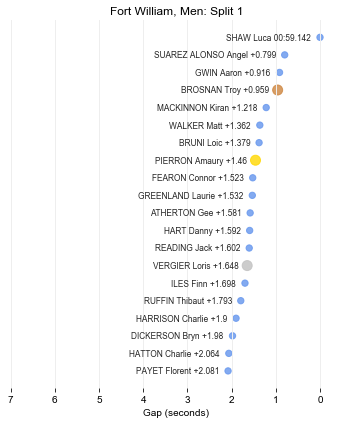

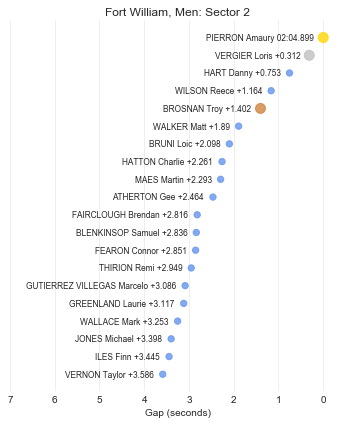

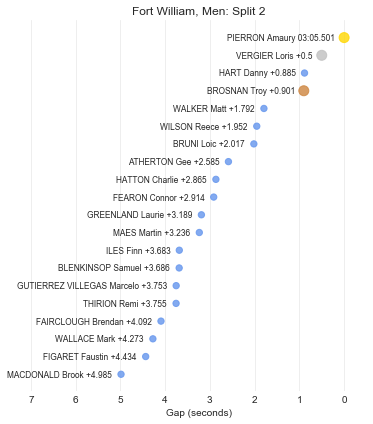

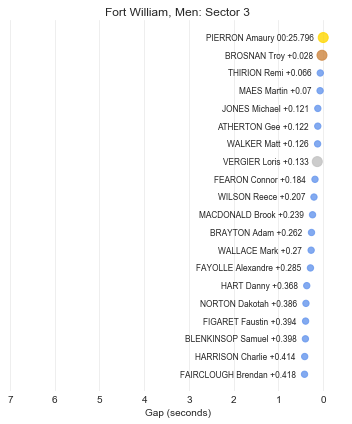

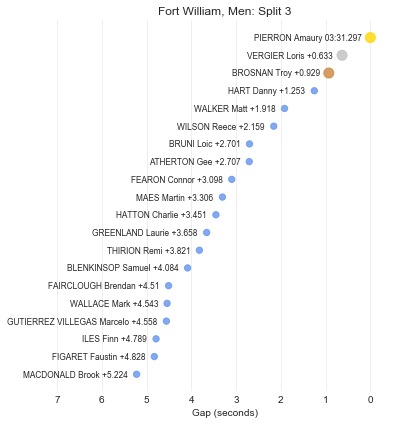

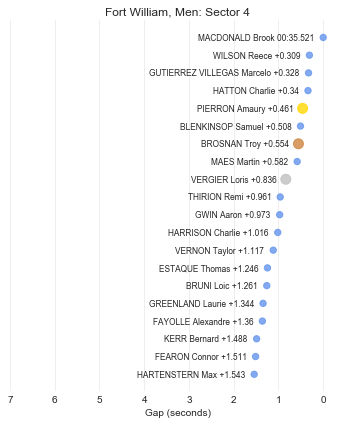

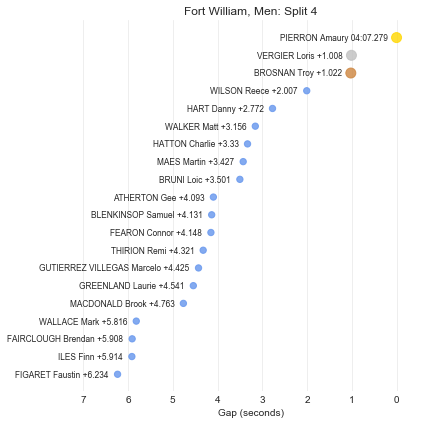

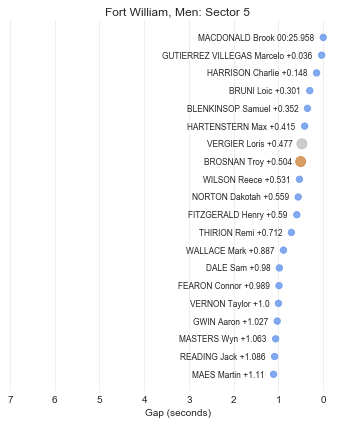

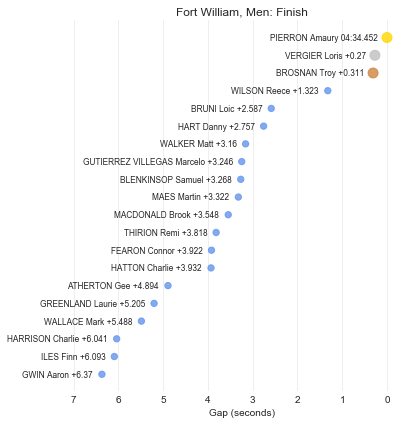

In [15]:
for i in range( 1, splits+1 ):
    x = str(i)
    split = 'split' + x

    if i > 1:
        col2 = split + '_sector_vs_best'
        dfSector = df.sort_values( col2, ascending=True ).reset_index( drop=True )
        drawScatter( dfSector, col2, chart_title_prefix + ': Sector ' + x, minX=minX, labelPosOffsetX=labelPosOffsetX )

    col = split + '_vs_best'
    dfSplit = df.sort_values(col, ascending=True).reset_index(drop=True)
    drawScatter( dfSplit, col, ( chart_title_prefix + ': Split ' + x if i < splits else chart_title_prefix + ': Finish' ), minX=minX, labelPosOffsetX=labelPosOffsetX )

### Position Consistency Heatmaps

Calculating chart size best fit

In [16]:
pltX = 1.4 * splits
pltY = 4 * ( topX / 10 )

Build list of riders for Y-axis, adding their finishing position next to them 

In [17]:
ylabels = [ j + ": " + str(i+1) for i, j in enumerate(df.name[:topX]) ]

Build data subset of ranking for each timing sector, then visualize consistency on a heatmap

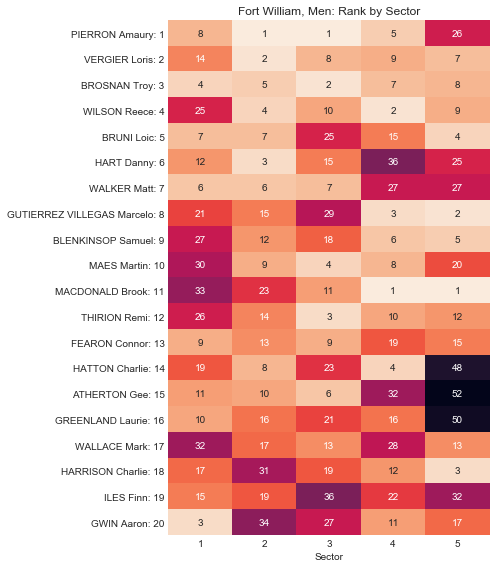

In [18]:
dfSectorRank = df[['split1_rank', 'split2_sector_rank', 'split3_sector_rank', 'split4_sector_rank', 'split5_sector_rank']][:topX].copy()
plt.figure(figsize=(pltX, pltY))
map = sns.heatmap(dfSectorRank, annot=True, yticklabels=ylabels, xticklabels=range(1,splits+1), cmap=sns.cm.rocket_r, cbar=False)
plt.xlabel( 'Sector' )
plt.title( chart_title_prefix + ': Rank by Sector' )
plt.tight_layout()
if image_gen:
    plt.savefig( file_prefix + '_heatmap_sectors.png', dpi=dpi )

Same as before but this time ranking for each race split, then visualize on a heatmap

On this heatmap, each rider represented will ideally gradually move darker to lighter left to right as their position improves toward the finish, unless they're winning from the start in which case it would stay the same (like Gwin from 2 onward)

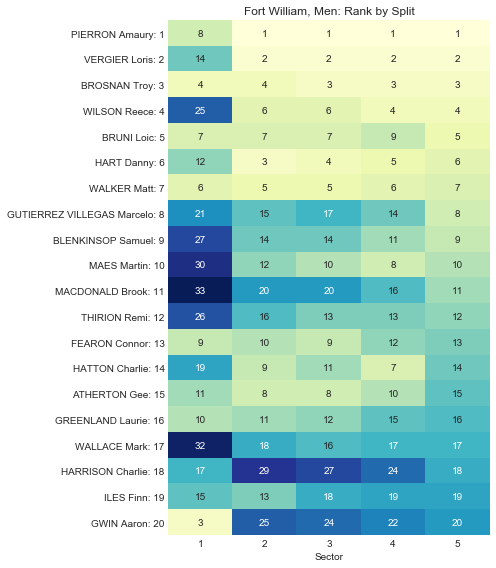

In [19]:
# Prepare data
dfSplitRank = df[['split1_rank', 'split2_rank', 'split3_rank', 'split4_rank', 'split5_rank']][:topX].copy()

# Configure and build heatmap
plt.figure(figsize=(pltX, pltY))
sns.heatmap( dfSplitRank, annot=True, yticklabels=ylabels, xticklabels=range(1,splits+1), cmap="YlGnBu", cbar=False )
plt.xlabel( 'Sector' )
plt.title( chart_title_prefix + ': Rank by Split' )
plt.tight_layout()
if image_gen:
    plt.savefig( file_prefix + '_heatmap_splits.png', dpi=dpi )

### Position Tracker Line Chart

This chart contains the same information as the second heatmap above but more clearly shows how riders changed positions as the race progressed until their final finishing place

We start by building up some lists of colors and lines styles to make the chart a little easier to read

These lists are then used to build a color map and a bunch of other stuff calculated and configured before finally displayin the line chart

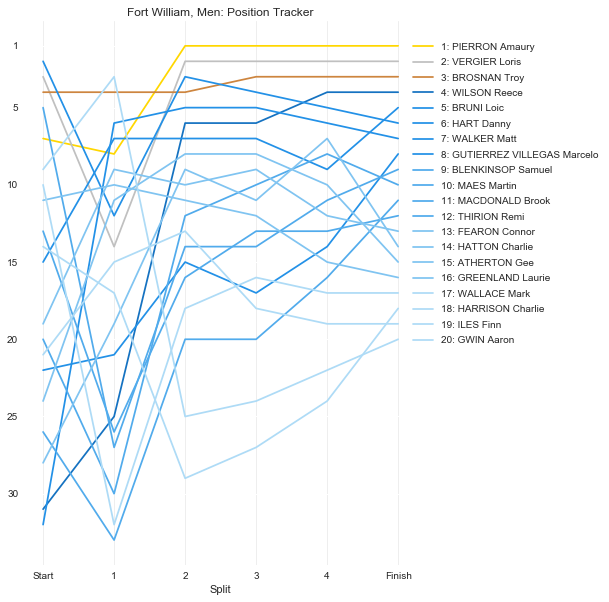

In [20]:
color1 = Color( '#2171b5' )
color2 = Color( '#bdd7e7' )
colorSat = 0.8
color1.saturation = colorSat
color2.saturation = colorSat
colors = list( color1.range_to( color2 , 5) )
colors = list( np.repeat( [ i.web for i in colors ], 4 ) )

colors[int(df.loc[df['rank'] == 1].index.values)] = "gold"
colors[int(df.loc[df['rank'] == 2].index.values)] = "silver"
colors[int(df.loc[df['rank'] == 3].index.values)] = "peru"
# lines = 5*['-', '--', '-.', ':']
lines = 20*['-']

data = df[['start_rev', 'split1_rank', 'split2_rank', 'split3_rank', 'split4_rank', 'split5_rank']][:topX].copy().T

mpl.style.use('seaborn')

cyc = cycler('color', colors) + cycler('linestyle', lines)
mpl.rcParams['axes.prop_cycle'] = cycler(cyc)

pltX = 1.4 * splits
pltY = 5 * ( topX / 10 )

fig = plt.figure( figsize=(pltX, pltY) )
plt.plot( data, label=True )
ax = plt.gca()
ax.invert_yaxis()
ax.set_facecolor('xkcd:white')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# plt.box(on=None)


plt.xlabel( 'Split' )
plt.title( chart_title_prefix + ': Position Tracker' )

maxY = int(dfSplitRank['split1_rank'].max()+1)
plt.yticks( [1]+list(range( 5, maxY, 5 )), [1]+list(range( 5, maxY, 5 )) )
xlabels = ['Start'] + [ str(i) for i in range( 1, splits ) ] + ['Finish']
plt.xticks( range( 0, splits+1 ), xlabels )
plt.grid( True, which='major', axis='y' )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )

if 2 == race:
    lspace = 0.644
else:
    lspace = 0.344

handles, labels = ax.get_legend_handles_labels()
# labelY = df['name'][:topX].values.tolist()
legendlabels = [ str(i+1) + ": " + j for i, j in enumerate(df.name[:topX]) ]
lgd = ax.legend( handles, legendlabels, loc=1, labelspacing=lspace, bbox_to_anchor=(1.49, 0.977)) #, handletextpad=1

# plt.savefig( file_prefix + '_position_tracker.png', dpi=300 ) # Doesn't fit legend
# Fix from: https://stackoverflow.com/questions/10101700/moving-matplotlib-legend-outside-of-the-axis-makes-it-cutoff-by-the-figure-box
if image_gen:
    plt.savefig( file_prefix + '_position_tracker.png', dpi=dpi, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

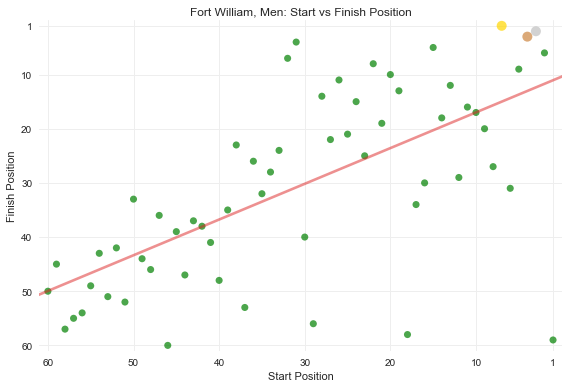

In [21]:
col = 'rank'
df2 = df.sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)

color = "green"
colors = [color]*(len(df2[col]))
colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
sizes = [50]*(len(df2[col]))
sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100


plot = sns.regplot( df2['start_rev'], df2['rank'], scatter_kws={"s": sizes, "alpha": 0.7, "color": colors}, line_kws={'color': '#DD2222', "alpha": 0.5}, ci=None)

# Format the chart
sns.despine()
plot.set_frame_on(False)
sns.set_style('whitegrid')
plot.grid( color='#EEEEEE', linewidth=1.0 )
plot.set( title=chart_title_prefix + ': Start vs Finish Position', xlabel='Start Position', ylabel='Finish Position' )

plot.invert_yaxis()
plot.invert_xaxis()
tick = [1]+list(range( 10, len(df2), 10 ))
plt.yticks( tick, tick )
plt.xticks( tick, tick )

plt.xlim( 61, 0 )
plt.ylim( 61, 0 )

plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_start_vs_finish.png', dpi=dpi )

In [22]:
# col = 'speed_ms_vs_best'
# df2 = df.sort_values(col, ascending=True)
# df2 = df2.reset_index(drop=True)
# drawScatter( df2, col, chart_title_prefix + ': Speed Trap', timeCol='speed_ms_vs_best', xlabel='Distance behind at speed trap (m)', minX=1, maxX=-.1, labelPosOffsetX=.03 )

In [23]:
# col = 'speed'
# df2 = df.sort_values(col, ascending=False)
# df2 = df2.reset_index(drop=True)
# drawScatter( df2, col, chart_title_prefix + ': Speed Trap', timeCol='speed', xlabel='Speed (km/m)', minX=df2.head(topX).speed.min()-.2, maxX=df2.speed.max()+.1, labelPosOffsetX=-.06 )

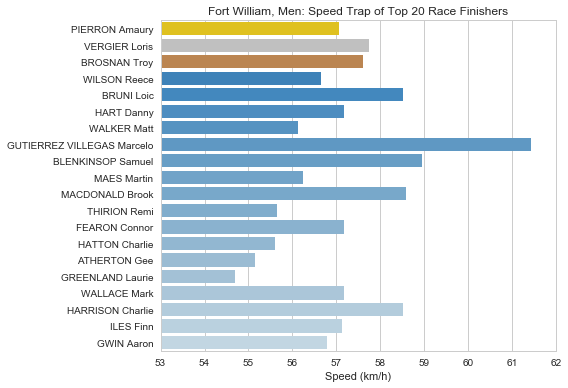

In [24]:
col = 'rank'
df2 = df.sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)

color1 = Color( '#2171b5' )
color2 = Color( '#bdd7e7' )
colors = list( color1.range_to( color2 , topX) )
colors = [ i.web for i in colors ]
colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
cyc = cycler('color', colors)
mpl.rcParams['axes.prop_cycle'] = cycler(cyc)

plot = sns.barplot( df2['speed'][:20], df2.name[:20])
plot.set( title=chart_title_prefix + ': Speed Trap of Top ' + str(topX) + ' Race Finishers', xlabel='Speed (km/h)', ylabel='' )

minX = math.floor( df2.speed[:topX].min()-1 )
maxX = math.ceil( df2.speed[:topX].max() )
plt.xlim( minX, maxX )
plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_speed_top_finishers.png', dpi=dpi )

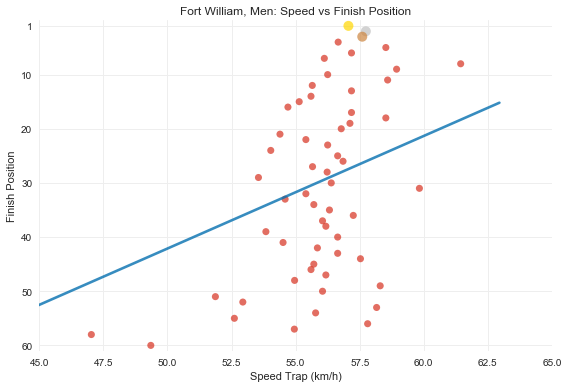

In [25]:
col = 'rank'
df2 = df.sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)

color = "#d7301f"
colors = [color]*(len(df2[col]))
colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
sizes = [50]*(len(df2[col]))
sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100

plot = sns.regplot( df2['speed'], df2['rank'], ci=None, line_kws={'color': '#0570b0', "alpha": 0.8}, scatter_kws={"s": sizes, "alpha": 0.7, "color": colors})
plot.invert_yaxis()
plot.set_frame_on(False)
plot.set( title=chart_title_prefix + ': Speed vs Finish Position', xlabel='Speed Trap (km/h)', ylabel='Finish Position' )
tick = [1]+list(range( 10, len(df2), 10 ))
plt.yticks( tick, tick )
plt.grid( True, which='major', axis='y', color='#EEEEEE' )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )

plt.ylim( 61, 0 )
if 1 == race:
    plt.xlim( 40, 50 )
elif 2 == race:
    plt.xlim( 45, 65 )

plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_speed_vs_finish.png', dpi=dpi )

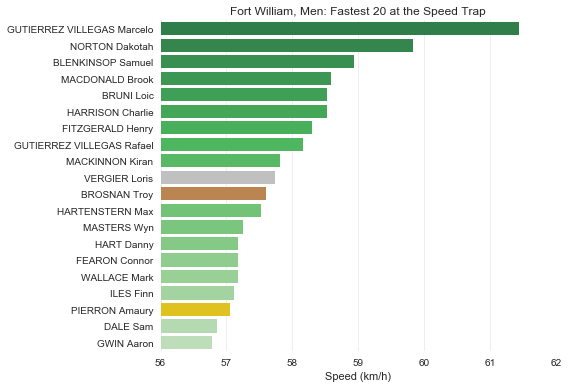

In [26]:
col = 'speed'
df2 = df.sort_values(col, ascending=False)
df2 = df2.reset_index(drop=True)

color1 = Color( '#238b45' )
color2 = Color( '#bae4b3' )
colors = list( color1.range_to( color2 , topX) )
colors = [ i.web for i in colors ]
first = int(df2.loc[df2['rank'] == 1].index.values)
second = int(df2.loc[df2['rank'] == 2].index.values)
third = int(df2.loc[df2['rank'] == 3].index.values)
if first <= topX:
    colors[first] = "gold"
if second <= topX:
    colors[second] = "silver"
if third <= topX:
    colors[third] = "peru"
cyc = cycler('color', colors)
mpl.rcParams['axes.prop_cycle'] = cycler(cyc)

plot = sns.barplot( df2.speed[:topX], df2.name[:topX])
plot.set( title=chart_title_prefix + ': Fastest ' + str(topX) + ' at the Speed Trap', xlabel='Speed (km/h)', ylabel='' )
plot.set_frame_on(False)
minX = math.floor( df2.speed[:topX].min() )
maxX = math.ceil( df2.speed[:topX].max() )
plt.xlim( minX, maxX )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )
plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_speed_fastest.png', dpi=dpi )

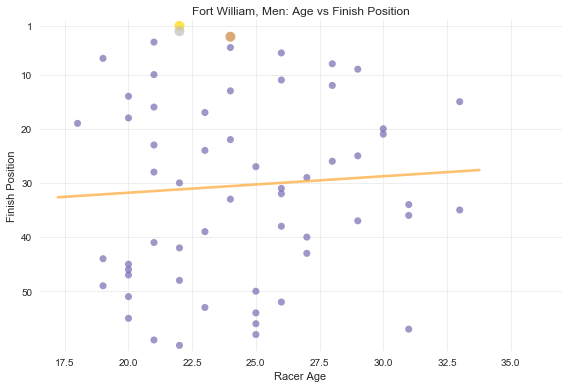

In [27]:
col = 'rank'
df2 = dfm[:60].sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)

colors = colorList( '#756bb1', '#756bb1', len(df2[col]) )

sizes = [50]*(len(df2[col]))
sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100

plot = sns.regplot( df2['Age'], df2['rank'], ci=None, line_kws={'color': '#feb24c', "alpha": 0.8}, scatter_kws={"s": sizes, "alpha": 0.7, "color": colors})
plot.invert_yaxis()
plot.set_frame_on(False)
plot.set( title=chart_title_prefix + ': Age vs Finish Position', xlabel='Racer Age', ylabel='Finish Position' )
tick = [1]+list(range( 10, len(df2), 10 ))
plt.yticks( tick, tick )
plt.grid( True, which='major', axis='y', color='#EEEEEE' )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )
plt.xlim( 16.5, 37 )
plt.ylim( 61, 0 )

plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_age_vs_finish.png', dpi=dpi )

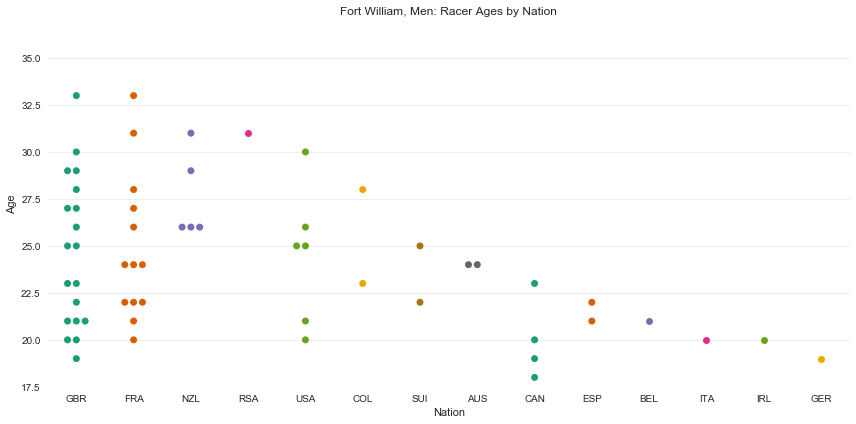

In [28]:
# plt.subplots(figsize=(30,10))
plt.figure(figsize=(12,6))
plot = sns.swarmplot( x='Nation', y='Age', data=dfm[:60].sort_values('Age', ascending=False), palette='Dark2', size=7 )
# sns.countplot( x='Nation', data=dfm.sort_values('Nation', ascending=True), palette='Blues_d' )


plot.set_frame_on(False)
plt.title(chart_title_prefix + ': Racer Ages by Nation')
plt.grid( True, which='major', axis='y', color='#EEEEEE' )
plt.ylim( 17.5, 37 )

plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_age_by_nation.png', dpi=dpi )

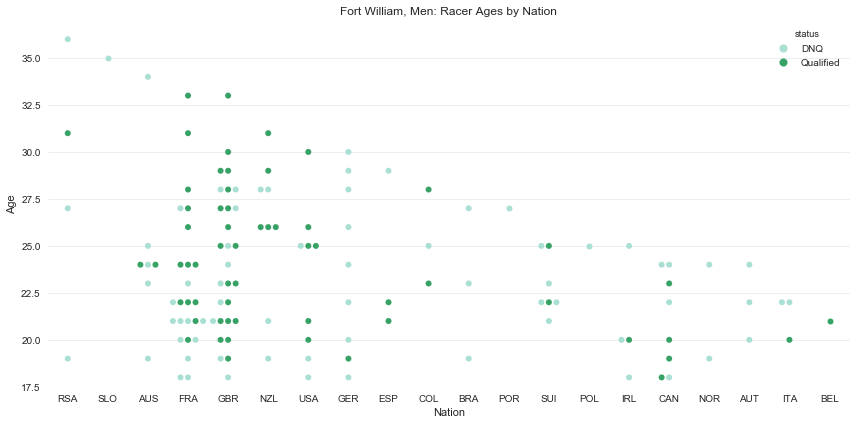

In [29]:
data = dfm.sort_values('Age', ascending=False)
data['status'].replace( to_replace='.+', value='Qualified', inplace=True, regex=True )
data['status'] = data['status'].fillna('DNQ')

plt.figure(figsize=(12,6))
plot = sns.swarmplot( x='Nation', y='Age', data=data, palette='BuGn', size=6, hue='status' )

plot.set_frame_on(False)
plt.title(chart_title_prefix + ': Racer Ages by Nation')
plt.grid( True, which='major', axis='y', color='#EEEEEE' )
plt.ylim( 17.5, 37 )

plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_age_by_nation.png', dpi=dpi )

In [30]:
# dfm.groupby( ['Nation'] )[['bib']].count().sort_values( 'bib', ascending=False )
# dfm.groupby( ['Nation'] )[['points']].sum().sort_values( 'points', ascending=False )

dfa = dfm[:60].groupby( ['Nation'] ).agg({
    'q_points': ['sum', 'mean']
    , 'r_points': ['sum', 'mean']
    , 'points': ['sum', 'mean']
    , 'bib': 'count'
    , 'Age': ['min', 'max', 'mean']
}).sort_values( [('points','mean')], ascending=False )
dfa[('q_points','mean')] = round(dfa[('q_points','mean')], 2)
dfa[('r_points','mean')] = round(dfa[('r_points','mean')], 2)
dfa[('points','mean')] = round(dfa[('points','mean')], 2)
dfa[('Age','mean')] = round(dfa[('Age','mean')], 2)
dfa.fillna(0, inplace=True)

# col = [('bib','count')]
# dfa[col] = dfa[dfa[col] > 1][col]
# dfa = dfa.dropna()
dfa = dfa.reset_index(drop=False)

dfa

Nation q_points        r_points         points           bib Age           
               sum   mean      sum    mean    sum    mean count min max   mean
0     AUS     43.0  21.50    200.0  100.00  243.0  121.50     2  24  24  24.00
1     BEL     16.0  16.00     75.0   75.00   91.0   91.00     1  21  21  21.00
2     FRA     45.0  22.50    743.0   57.15  788.0   60.62    13  20  33  24.92
3     COL     13.0  13.00     93.0   46.50  106.0   53.00     2  23  28  25.50
4     NZL     27.0  13.50    227.0   45.40  254.0   50.80     5  26  31  27.60
5     GBR    100.0  16.67    778.0   40.95  878.0   46.21    19  19  33  24.68
6     USA     84.0  21.00    155.0   25.83  239.0   39.83     6  20  30  24.50
7     CAN     20.0  10.00    114.0   28.50  134.0   33.50     4  18  23  20.00
8     ESP      0.0   0.00     34.0   17.00   34.0   17.00     2  21  22  21.50
9     GER      0.0   0.00     17.0   17.00   17.0   17.00     1  19  19  19.00
10    IRL      0.0   0.00     15.0   15.00   15.0   15.00     1  20  20  20.00
11    ITA      0.0   0.00     14.0   14.00   14.0   14.00     1  20  20  20.00
12    SUI      0.0   0.00     26.0   13.00   26.0   13.00     2  22  25  23.50
13    RSA      0.0   0.00      4.0    4.00    4.0    4.00     1  31  31  31.00

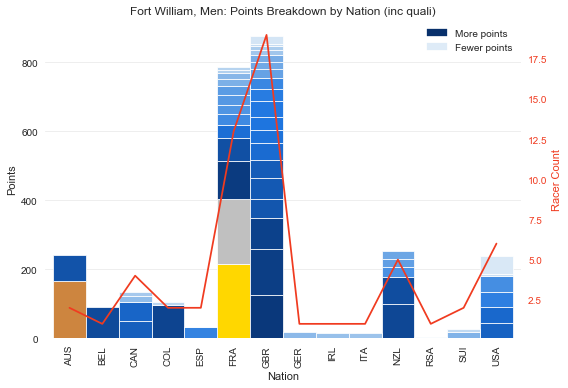

In [101]:
dfPoints = dfm[:60][['name', 'Nation', 'points']].copy().dropna()
dfPivot = dfPoints.pivot( index='Nation', columns='name', values='points' ).fillna(0)
dfPivot = dfPivot[dfm[:60]['name']] # Reorder columns
dfb = dfa.sort_values( ['Nation'], ascending=True )

colors = colorList( '#08306b', '#deebf7', len(dfPoints) )

ax = dfPivot.plot.bar( stacked=True, color=colors, edgecolor='white', linewidth=.75, width=1 )
leg1 = mpatches.Patch(color='#08306b', label='More points')
leg2 = mpatches.Patch(color='#deebf7', label='Fewer points')
ax.legend_.remove()
plt.legend( handles=[leg1, leg2])
plt.title(chart_title_prefix + ': Points Breakdown by Nation (inc quali)')
ax.set_ylabel( 'Points' )

ax2 = ax.twinx()
ax2.plot( dfb['Nation'], dfb['bib']['count'], '#f03b20' )
ax2.set_ylabel('Racer Count', color='#f03b20')
ax2.tick_params('y', colors='#f03b20', zorder='0')

ax.grid( False, which='major', axis='y', color='#EEEEEE' )
ax2.grid( False, which='major', axis='y' )
ax.grid( False, which='major', axis='x' )
ax2.grid( False, which='major', axis='x' )

ax.set_frame_on(False)
ax2.set_frame_on(False)
plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_points_by_nation.png', dpi=dpi )

Team Performance

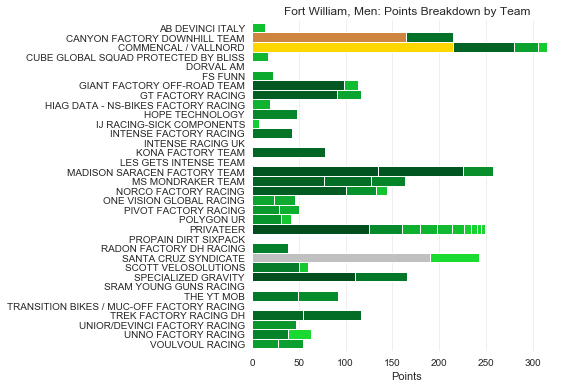

In [96]:
dfTeams = dfm[['name', 'UciTeamName', 'points']].copy().fillna('PRIVATEER')
dfTeamPoints = dfTeams.pivot( index='UciTeamName', columns='name', values='points' ).fillna(0)
dfTeamPoints = dfTeamPoints[dfm[:60]['name']]
dfTeamPoints = dfTeamPoints.sort_index( ascending=False )

colors = colorList( '#00441b', '#e5f5e0', len(df) )

ax = dfTeamPoints.plot.barh( stacked=True, color=colors, edgecolor='white', linewidth=1, width=1 )
ax.legend_.remove()
plt.title(chart_title_prefix + ': Points Breakdown by Team')
ax.set_xlabel( 'Points' )
ax.set_ylabel( '' )

ax.grid( False, which='major', axis='y' )
ax.grid( False, which='major', axis='x', color='#EEEEEE' )

ax.set_frame_on(False)
ax2.set_frame_on(False)
plt.tight_layout()

if image_gen:
    plt.savefig( file_prefix + '_points_by_team.png', dpi=dpi )

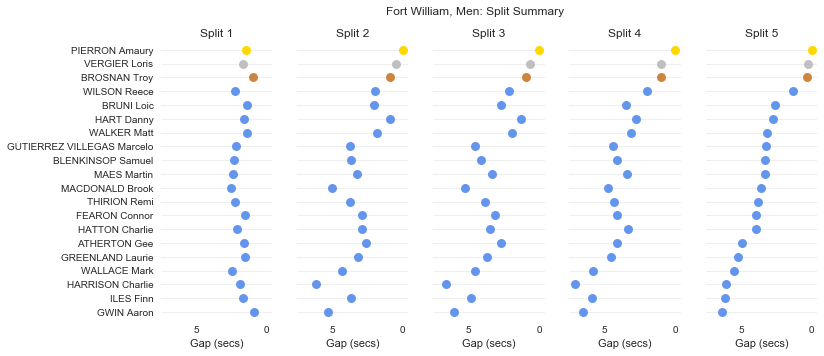

In [33]:
# https://seaborn.pydata.org/examples/pairgrid_dotplot.html
data = dfm[0:topX]

# Make the PairGrid
g = sns.PairGrid( data, x_vars=['split1_vs_best', 'split2_vs_best', 'split3_vs_best', 'split4_vs_best', 'split5_vs_best'], y_vars=["name"], size=5, aspect=.4)

# Draw a dot plot using the stripplot function
colors = colorList( '#6495ED', '#6495ED', len(data) )
g.map( sns.stripplot, size=9, orient="h", palette=colors, edgecolor="gray" )

# Use the same x axis limits on all columns and add better labels
g.set( xlim=(7.5, -.4), xlabel="Gap (secs)", ylabel="" ) # xlim=(0, 25),

# Use semantically meaningful titles for the columns
titles = ["Split 1", "Split 2", "Split 3", "Split 4", "Split 5"]

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid( False )
    ax.yaxis.grid( color='#EEEEEE' )

# Chart Visuals
sns.despine( left=True, bottom=True )
plt.subplots_adjust( top=0.88 )
g.fig.suptitle( chart_title_prefix + ': Split Summary' )

# Image export
if image_gen:
    plt.gcf().subplots_adjust(left=0.22)
    plt.savefig( file_prefix + '_split_summary.png', dpi=dpi )

#### Comparing qualifying and finals times

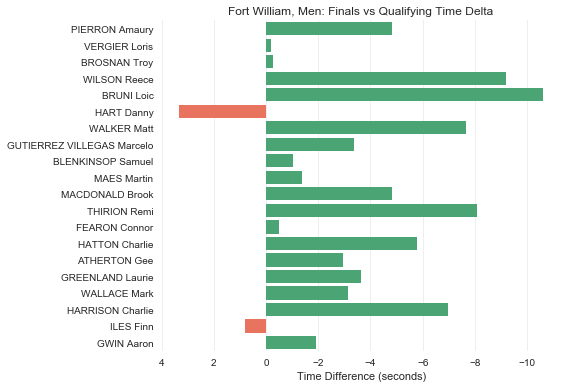

In [34]:
data = dfm.sort_values( 'rank', ascending=True )[:20]
colors = colorList( '#6495ED', '#6495ED', len(data) )
colors = [ 'tomato' if 0 < i else 'mediumseagreen' for i in data['qr_diff'] ]
data['qr_pm'] = [ True if 0 < i else False for i in data['qr_diff'] ]
plot = sns.barplot( data['qr_diff'], data['name'], palette=colors )
plot.set_frame_on(False)
plot.set( title=chart_title_prefix + ': Finals vs Qualifying Time Delta', xlabel='Time Difference (seconds)', ylabel='' )
plot.invert_xaxis()
plt.grid( True, which='major', axis='x', color='#EEEEEE' )
plt.tight_layout()

# Image export
if image_gen:
    plt.savefig( file_prefix + '_finals_vs_qualis_delta.png', dpi=dpi )

<Figure size 576x396 with 0 Axes>

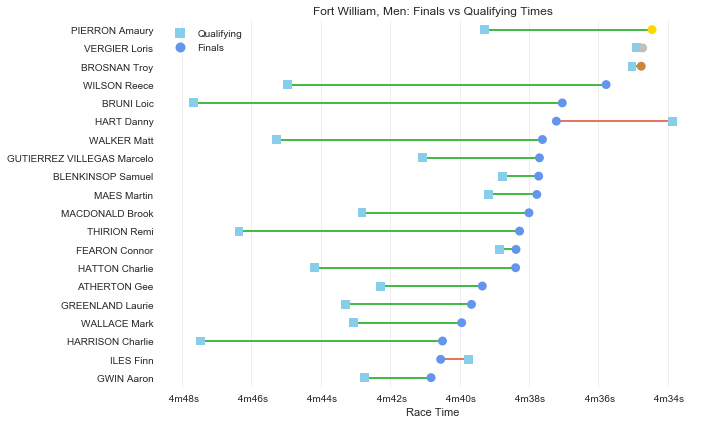

In [74]:
plt.clf()
color='CornflowerBlue'
colors = colorList( color, color, topX )
colors2 = [ 'skyblue' ]* topX
colors3 = [ 'tomato' if 0 < i else 'limegreen' for i in dfm['qr_diff'][:topX] ]

plt.figure(figsize=(10,6))
data = dfm[['name','rank','q_split5']].copy().rename( columns={'q_split5':'split5'})
data = dfm[['name','rank','split5']].copy().append( data, ignore_index=True ).dropna().sort_values( 'rank').reset_index(drop=True)

# Marker shapes: https://python-graph-gallery.com/41-control-marker-features/
plot2 = sns.regplot( y=df2.index.values[:topX], x=df2['q_split5'][:topX], fit_reg=False, scatter_kws={ 'color': colors2, 's': 80, 'alpha': 1 }, marker='s' ) # , 'facecolors': 'none'
plot1 = sns.regplot( y=df2.index.values[:topX], x=df2['split5'][:topX], fit_reg=False, scatter_kws={ 'color': colors, 's': 80, 'alpha': 1 }, marker='o' )
plt.setp(plot1.lines, zorder=100)
plt.setp(plot1.collections, zorder=100, label="")
plt.setp(plot2.lines, zorder=100)
plt.setp(plot2.collections, zorder=100, label="")
plot = sns.boxplot( x='split5', y='name', data=data[:40], palette=colors3, whis=True, width=0, linewidth=2, fliersize=0, ax=plot1 )

# Source: https://matplotlib.org/users/legend_guide.html
leg1 = mlines.Line2D( [], [], color='skyblue', marker='s', markersize=10, label='Qualifying', linestyle='' )
leg2 = mlines.Line2D( [], [], color='cornflowerblue', marker='o', markersize=10, label='Finals', linestyle='' )
plt.legend( handles=[leg1, leg2] )

sns.despine()
plot.invert_xaxis()
plot.set_frame_on(False)
plt.grid( True, which='major', axis='x', color='#EEEEEE' )
plot.set( title=chart_title_prefix + ': Finals vs Qualifying Times', xlabel='Race Time', ylabel='' )

# Source: https://stackoverflow.com/questions/36874697/how-to-edit-properties-of-whiskers-fliers-caps-etc-in-seaborn-boxplot
for i, artist in enumerate( plot.artists ):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = plot.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

plt.tight_layout()
        
# Source: https://stackoverflow.com/questions/42813744/seaborn-boxplot-get-the-xtick-labels
xticks = [ secondsToRaceTime( int(t.get_text()) ) if 'm' not in t.get_text() else t.get_text() for t in plot.get_xticklabels() ]
plot.set_xticklabels( xticks )

# Image export
if image_gen:
    plt.savefig( file_prefix + '_finals_vs_qualis_compare.png', dpi=dpi )

Expectation rating: UCI Rank / Points Won

In [37]:
# dfx = dfm[['name', 'points', 'WorldCupRank', 'UciRank', 'start_rev']].copy().dropna()
# dfx['UciPerf'] = dfx['UciRank'] / dfx['points']
# dfx['SeriesPerf'] = dfx['start_rev'] / dfx['points']
# dfx = dfx.sort_values( ['SeriesPerf'], ascending=False )
# dfx

--- 

## Credits

### Author: Dominic Wrapson


> **@domwrap**
<br>
<a href="https://github.com/domwrap/"><img src="https://png.icons8.com/material/24/000000/github-2.png"></a>
<a href="https://stackoverflow.com/users/2154487/domwrap"><img src="https://png.icons8.com/material/24/000000/stackoverflow.png"></a>
<a href="https://www.linkedin.com/in/domwrap"><img src="https://png.icons8.com/material/24/000000/linkedin.png"></a>
<a href="https://notebooks.azure.com/domwrap"><img src="https://png.icons8.com/material/24/000000/windows8.png"></a>
<a href="https://www.instagram.com/domwrap"><img src="https://png.icons8.com/ios-glyphs/24/000000/instagram-new.png"></a>
<a href="http://twitter.com/domwrap"><img src="https://png.icons8.com/material/24/000000/twitter.png"></a>
<a href="https://medium.com/@domwrap"><img src="https://png.icons8.com/material/24/000000/medium-logo.png"></a>
>
> <img src="https://png.icons8.com/material/24/000000/home.png"> http://domwrap.me
>
><img src="https://png.icons8.com/material/24/000000/cycling-mountain-bike.png"> [Hwulex](https://www.pinkbike.com/u/Hwulex/)


---

#### Special Thanks

Mark Shilton for the inspiration
- http://lookatthestats.blogspot.ca
- https://plus.google.com/+MarkShilton
- https://dirtmountainbike.com/author/mrgeekstats


<a href="https://icons8.com">Icon pack by Icons8</a>